In [1]:
import glob
import numpy as np
import gpflow
import pandas as pd

from lineshape_meanfuncs import LineShape, lineshape_from_dataframe, Etalon, ComboMeanFunc
from gp_models import SwitchedGPR

import matplotlib.pyplot as plt

HAPI version: 1.1.0.9.6
To get the most up-to-date version please check http://hitran.org/hapi
ATTENTION: Python versions of partition sums from TIPS-2017 are now available in HAPI code

           It is free to use HAPI. If you use HAPI in your research or software development,
           please cite it using the following reference:
           R.V. Kochanov, I.E. Gordon, L.S. Rothman, P. Wcislo, C. Hill, J.S. Wilzewski,
           HITRAN Application Programming Interface (HAPI): A comprehensive approach
           to working with spectroscopic data, J. Quant. Spectrosc. Radiat. Transfer 177, 15-30 (2016)
           DOI: 10.1016/j.jqsrt.2016.03.005


# Read in some data

In [2]:
dat_files = glob.glob('/Users/jim2/CCI/MATS/MATS/MATS/Examples/A-Band - Experimental Spectra/*forfit.csv')
dat_files

['/Users/jim2/CCI/MATS/MATS/MATS/Examples/A-Band - Experimental Spectra/190513_2per_82_forfit.csv',
 '/Users/jim2/CCI/MATS/MATS/MATS/Examples/A-Band - Experimental Spectra/190514_2per_126_forfit.csv',
 '/Users/jim2/CCI/MATS/MATS/MATS/Examples/A-Band - Experimental Spectra/190510_2per_43_forfit.csv',
 '/Users/jim2/CCI/MATS/MATS/MATS/Examples/A-Band - Experimental Spectra/190510_2per_55_forfit.csv']

In [3]:
dat = [np.loadtxt(f, delimiter=',', skiprows=1) for f in dat_files]

In [4]:
x = [d[:, [3, 10, 11]] for d in dat]
for d in x:
    d[:, 0] *= (10**6) / 29979245800
    d[:, 1] += 273.15
    d[:, 2] /= 760.0
    
x = [np.hstack([x[i], np.ones((x[i].shape[0], 1))*i]) for i in range(len(x))]

y = [d[:, 9] for d in dat]

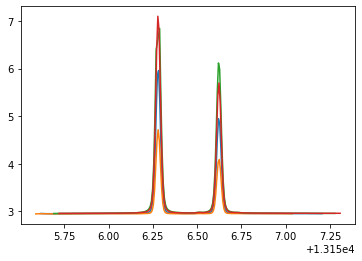

In [5]:
fig, ax = plt.subplots()
for i in range(len(x)):
    ax.plot(x[i][:, 0], y[i])
plt.show()

# Perform some fitting

In [22]:
#Define a noise scale to make training a little more robust
noise_scale = 10.0*np.average([np.std(y[i][:10]) for i in range(len(y))])
print(noise_scale)

0.008708101055790094


In [23]:
# #For now specifying each lineshape manually, but in future, should have function to create from csv or dataframe
# #(from Params_Linelist.csv or something like that)
# #Actually, see below instead of this and the next cell
# lineshape10 = LineShape(7, 1,
#                            nu=[13156.280289119526, 13156.280291721692, 13156.28030888393, 13156.28024758947], #[13156.28, 13156.28, 13156.28, 13156.28], #By providing multiple values, fits datasets separately
#                            sw=[4.732494282467316, 4.749804083254489, 4.742357275274134, 4.798440324146192], #[4.799, 4.799, 4.799, 4.799],
#                            elower=343.75,
#                            sw_scale_fac=1e-24,
#                            mole_frac=0.01949,
#                            delta0=-0.007967,
#                            n_delta0=2.4e-05,
#                            n_gamma0=0.81,
#                            n_gamma2=0.81,
#                            gamma0=0.04487, sd_gamma=0.11240, #These are the optimized values of these parameters from MATS
#                            constraint_dict={'sd_gamma':(0.01, 0.25),
#                                             'nu':(13156.18, 13156.38),
#                                             'sw':(4.799/2.0, 2.0*4.799)},
#                            cutoff=25,
#                            noise_scale_factor=noise_scale,
#                           )

# #Will optimize nu, sw, gamma0, and sd_gamma according to example, fixing everything else
# gpflow.set_trainable(lineshape10.y, False)
# gpflow.set_trainable(lineshape10.eta, False)
# gpflow.set_trainable(lineshape10.sd_delta, False)
# gpflow.set_trainable(lineshape10.nuvc, False)
# gpflow.set_trainable(lineshape10.delta0, False)

# lineshape13 = LineShape(7, 1,
#                            nu=[13156.623279631729, 13156.623256573897, 13156.623265166603, 13156.62322119959], #[13156.62, 13156.62, 13156.62, 13156.62],
#                            sw=[3.0863800251308744, 3.0908107944101064, 3.0943070628870744, 3.117088881953248], #[3.123, 3.123, 3.123, 3.123],
#                            elower=440.56,
#                            sw_scale_fac=1e-24,
#                            mole_frac=0.01949,
#                            delta0=-0.008546999999999999,
#                            n_delta0=2.8000000000000013e-05,
#                            n_gamma0=0.8,
#                            n_gamma2=0.8,
#                            gamma0=0.04331, sd_gamma=0.13064, #These are the optimized values of these parameters from MATS
#                            constraint_dict={'sd_gamma':(0.01, 0.25),
#                                             'nu':(13156.52, 13156.72),
#                                             'sw':(3.123/2.0, 2.0*3.123)},
#                            cutoff=25,
#                            noise_scale_factor=noise_scale,
#                           )
# gpflow.set_trainable(lineshape13.y, False)
# gpflow.set_trainable(lineshape13.eta, False)
# gpflow.set_trainable(lineshape13.sd_delta, False)
# gpflow.set_trainable(lineshape13.nuvc, False)
# gpflow.set_trainable(lineshape13.delta0, False)

In [24]:
# #Lineshapes included in the simulated model but not fit
# lineshape1 = LineShape(7, 1,
#                         nu=13154.18,
#                         sw=4.369,
#                         elower=345.85,
#                         sw_scale_fac=1e-24,
#                         mole_frac=0.01949,
#                         delta0=-0.007977,
#                         n_delta0=2.5e-05,
#                         n_gamma0=0.8,
#                         n_gamma2=0.8,
#                         gamma0=0.04,
#                         sd_gamma=0.1,
#                         cutoff=25,
#                         noise_scale_factor=noise_scale,
#                         )
# for param in lineshape1.trainable_parameters:
#     gpflow.set_trainable(param, False)

# lineshape25 = LineShape(7, 1,
#                                  nu=13158.68,
#                                  sw=2.083,
#                                  elower=546.7,
#                                  sw_scale_fac=1e-24,
#                                  mole_frac=0.01949,
#                                  delta0=-0.0087411,
#                                  n_delta0=3.3e-05,
#                                  n_gamma0=0.77,
#                                  n_gamma2=0.77,
#                                  gamma0=0.04,
#                                  sd_gamma=0.09,
#                                  cutoff=25,
#                                  noise_scale_factor=noise_scale,
#                                 )
# for param in lineshape25.trainable_parameters:
#     gpflow.set_trainable(param, False)

# lineshape26 = LineShape(7, 1,
#                                  nu=13158.74,
#                                  sw=3.39899999,
#                                  elower=438.44,
#                                  sw_scale_fac=1e-24,
#                                  mole_frac=0.01949,
#                                  delta0=-0.0085680,
#                                  n_delta0=2.899999999999e-05,
#                                  n_gamma0=0.82,
#                                  n_gamma2=0.82,
#                                  gamma0=0.04,
#                                  sd_gamma=0.1,
#                                  cutoff=25,
#                                  noise_scale_factor=noise_scale,
#                                 )
# for param in lineshape26.trainable_parameters:
#     gpflow.set_trainable(param, False)


In [25]:
lineparam_list = pd.read_csv('Parameter_LineList.csv', index_col=0)
lineshape10 = lineshape_from_dataframe(lineparam_list[10:11],
                                       limit_factor_dict={'SD_gamma':('factor', 2.0),
                                                          'nu':('magnitude', 0.1),
                                                          'sw':('limit', 2.0)},
                                       line_kwargs={'cutoff':25,
                                                    'noise_scale_factor':noise_scale,
                                                    'mole_frac':0.01949})
lineshape13 = lineshape_from_dataframe(lineparam_list[13:14],
                                       limit_factor_dict={'SD_gamma':('factor', 2.0),
                                                          'nu':('magnitude', 0.1),
                                                          'sw':('limit', 2.0)},
                                       line_kwargs={'cutoff':25,
                                                    'noise_scale_factor':noise_scale,
                                                    'mole_frac':0.01949})
lineshape1 = lineshape_from_dataframe(lineparam_list[1:2],
                                       line_kwargs={'cutoff':25,
                                                    'noise_scale_factor':noise_scale,
                                                    'mole_frac':0.01949})
lineshape25 = lineshape_from_dataframe(lineparam_list[25:26],
                                       line_kwargs={'cutoff':25,
                                                    'noise_scale_factor':noise_scale,
                                                    'mole_frac':0.01949})
lineshape26 = lineshape_from_dataframe(lineparam_list[26:27],
                                       line_kwargs={'cutoff':25,
                                                    'noise_scale_factor':noise_scale,
                                                    'mole_frac':0.01949})

In [26]:
#And etalons
etalon1 = Etalon(0.00165, 1.271443, -0.734156, np.min(x[0][:, 0]), noise_scale_factor=noise_scale)
etalon2 = Etalon(0.00165, 1.271443, -0.480252, np.min(x[1][:, 0]), noise_scale_factor=noise_scale)
etalon3 = Etalon(0.00165, 1.271443, -1.417825, np.min(x[2][:, 0]), noise_scale_factor=noise_scale)
etalon4 = Etalon(0.00165, 1.271443, -1.647160, np.min(x[3][:, 0]), noise_scale_factor=noise_scale)

In [27]:
#Put it all together in the combined mean function for the model
mean_func = ComboMeanFunc([lineshape1, lineshape10, lineshape13, lineshape25, lineshape26,
                           etalon1, etalon2, etalon3, etalon4,
                          ]
                         )

In [28]:
#Create gpflow model
gpflow.config.set_default_jitter(1e-06)

test_x = np.vstack(x)
#Add column in y to indicate different likelihoods, i.e., different noise on different experimental datasets
test_y = np.vstack([np.vstack([y[i], np.ones_like(y[i])*i]).T for i in range(len(y))])
print(test_x.shape)
print(test_y.shape)

#Noise variance is around 1e-6 or 1e-07, which is an issue for GPflow
#To avoid numerical problems, scale output by noise standard deviation so noise variance will be order 1
test_y[:, 0] /= noise_scale

#Specify kernel that ignores the dimension specifying just the dataset index
# kern = gpflow.kernels.SquaredExponential(lengthscales=1.0*(np.amax(test_x[:, :-1], axis=0)
#                                                            - np.amin(test_x[:, :-1], axis=0)),
#                                          active_dims=[0, 1, 2])
kern = gpflow.kernels.Linear(variance=[1.0, 1.0, 1.0], active_dims=[0, 1, 2])

#Define our Gaussian process regression model
gpr = SwitchedGPR(data=(test_x, test_y),
                  kernel=kern,
                  mean_function=mean_func,
                  noise_variance=[1.0]*len(y))

(928, 4)
(928, 2)


In [29]:
gpr

name,class,transform,prior,trainable,shape,dtype,value
SwitchedGPR.mean_function.mean_funcs[0].nu,Parameter,Identity,,False,"(4,)",float64,"[13154.18, 13154.18, 13154.18..."
SwitchedGPR.mean_function.mean_funcs[0].sw,Parameter,Identity,,False,"(4,)",float64,"[4.369, 4.369, 4.369..."
SwitchedGPR.mean_function.mean_funcs[0].gamma0,Parameter,Identity,,False,(),float64,0.04
SwitchedGPR.mean_function.mean_funcs[0].delta0,Parameter,Identity,,False,(),float64,-0.007977
SwitchedGPR.mean_function.mean_funcs[0].sd_gamma,Parameter,Identity,,False,(),float64,0.1
SwitchedGPR.mean_function.mean_funcs[0].sd_delta,Parameter,Identity,,False,(),float64,0.0
SwitchedGPR.mean_function.mean_funcs[0].nuvc,Parameter,Identity,,False,(),float64,0.0
SwitchedGPR.mean_function.mean_funcs[0].eta,Parameter,Identity,,False,(),float64,0.0
SwitchedGPR.mean_function.mean_funcs[0].y,Parameter,Identity,,False,(),float64,0.0
SwitchedGPR.mean_function.mean_funcs[1].nu,Parameter,Identity,,True,"(4,)",float64,"[13156.28028912, 13156.28029172, 13156.28030889..."


<IPython.core.display.Javascript object>


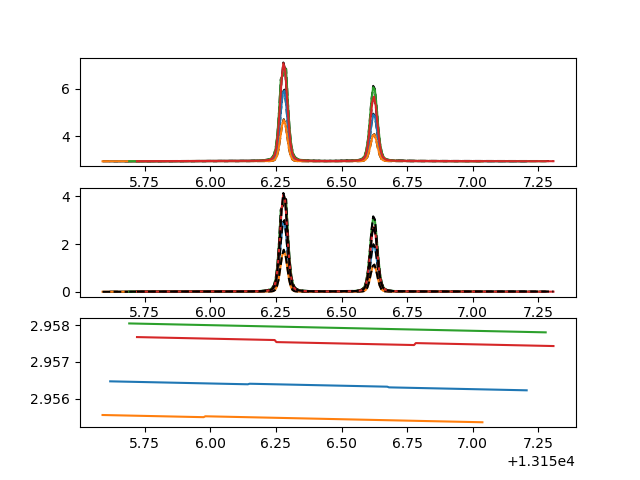

In [30]:
%matplotlib notebook

#Predictions before training
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red']

fig, ax = plt.subplots(3)

for i in range(len(x)):
    mean, var = gpr.predict_f(x[i])
    mean = noise_scale * mean[:, 0].numpy()
    var = (noise_scale**2) * var[:, 0].numpy()
    line = noise_scale * gpr.mean_function(x[i]).numpy().flatten()
    ax[0].errorbar(x[i][:, 0], mean, yerr=np.sqrt(var), color=colors[i])
    ax[0].plot(x[i][:, 0], y[i], 'k--')
    ax[1].plot(x[i][:, 0], line, color=colors[i])
    ax[1].plot(x[i][:, 0], y[i] - (mean - line), 'k--')
    ax[2].plot(x[i][:, 0], mean - line, color=colors[i])
    #ax[2].plot(x[i][:, 0], y[i] - line, 'k--')

plt.show()

<IPython.core.display.Javascript object>


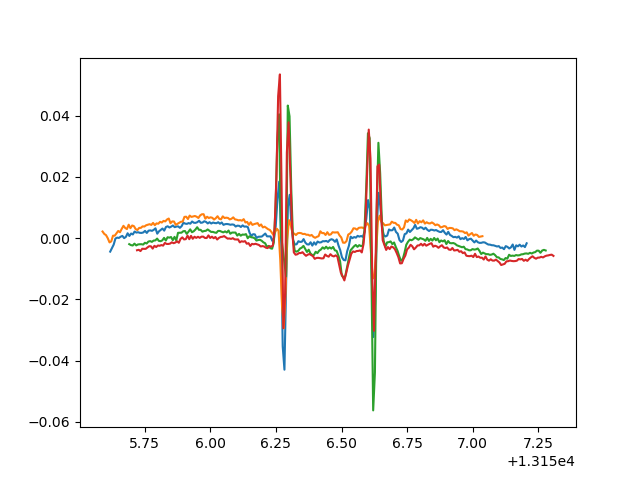

In [31]:
#Plot residuals
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red']

fig, ax = plt.subplots()

for i in range(len(x)):
    mean, var = gpr.predict_f(x[i])
    mean = noise_scale * mean[:, 0].numpy()
    var = (noise_scale**2) * var[:, 0].numpy()
    #ax.errorbar(x[i][:, 0], mean - y[i], yerr=np.sqrt(var), color=colors[i], alpha=0.5)
    ax.plot(x[i][:, 0], mean - y[i], color=colors[i])


In [32]:
opt = gpflow.optimizers.Scipy()

#First optimize the lineshapes without the GP model (baseline)
# gpflow.set_trainable(gpr.kernel.variance, False)
# gpflow.set_trainable(gpr.kernel.lengthscales, False)
# for l in gpr.likelihood.likelihoods:
#     gpflow.set_trainable(l.variance, False)
# opt_logs = opt.minimize(gpr.training_loss, gpr.trainable_variables, options=dict(maxiter=10))

#Or maybe try optimizing baseline first?
for m in gpr.mean_function.mean_funcs:
    if isinstance(m, LineShape):
        for param in ['nu', 'sw', 'gamma0', 'sd_gamma']:
            gpflow.set_trainable(getattr(m, param), False)
# opt_logs = opt.minimize(gpr.training_loss, gpr.trainable_variables, options=dict(maxiter=10))

#Then do all the parameters together
# gpflow.set_trainable(gpr.kernel.variance, True)
# gpflow.set_trainable(gpr.kernel.lengthscales, True)
# for l in gpr.likelihood.likelihoods:
#     gpflow.set_trainable(l.variance, True)
# for m in gpr.mean_function.mean_funcs:
#     if isinstance(m, LineShape):
#         for param in ['nu', 'sw', 'gamma0', 'sd_gamma']:
#             gpflow.set_trainable(getattr(m, param), True)
opt_logs = opt.minimize(gpr.training_loss, gpr.trainable_variables, options=dict(maxiter=500))

In [33]:
gpr

name,class,transform,prior,trainable,shape,dtype,value
SwitchedGPR.mean_function.mean_funcs[0].nu,Parameter,Identity,,False,"(4,)",float64,"[13154.18, 13154.18, 13154.18..."
SwitchedGPR.mean_function.mean_funcs[0].sw,Parameter,Identity,,False,"(4,)",float64,"[4.369, 4.369, 4.369..."
SwitchedGPR.mean_function.mean_funcs[0].gamma0,Parameter,Identity,,False,(),float64,0.04
SwitchedGPR.mean_function.mean_funcs[0].delta0,Parameter,Identity,,False,(),float64,-0.007977
SwitchedGPR.mean_function.mean_funcs[0].sd_gamma,Parameter,Identity,,False,(),float64,0.1
SwitchedGPR.mean_function.mean_funcs[0].sd_delta,Parameter,Identity,,False,(),float64,0.0
SwitchedGPR.mean_function.mean_funcs[0].nuvc,Parameter,Identity,,False,(),float64,0.0
SwitchedGPR.mean_function.mean_funcs[0].eta,Parameter,Identity,,False,(),float64,0.0
SwitchedGPR.mean_function.mean_funcs[0].y,Parameter,Identity,,False,(),float64,0.0
SwitchedGPR.mean_function.mean_funcs[1].nu,Parameter,Identity,,False,"(4,)",float64,"[13156.28028912, 13156.28029172, 13156.28030889..."


<IPython.core.display.Javascript object>


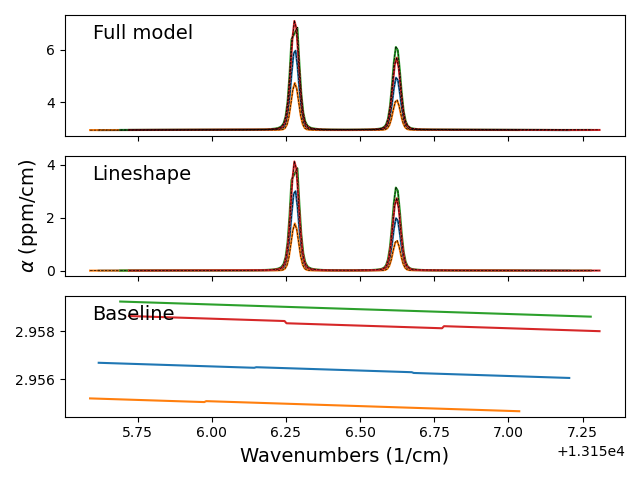

In [19]:
#Predictions after training
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red']

fig, ax = plt.subplots(3, sharex=True, sharey=False)

for i in range(len(x)):
    mean, var = gpr.predict_f(x[i])
    mean = noise_scale * mean[:, 0].numpy()
    var = (noise_scale**2) * var[:, 0].numpy()
    line = noise_scale * gpr.mean_function(x[i]).numpy().flatten()
    ax[0].errorbar(x[i][:, 0], mean, yerr=np.sqrt(var), color=colors[i])
    ax[0].plot(x[i][:, 0], y[i], 'k--', linewidth=0.5, zorder=3)
    ax[1].plot(x[i][:, 0], line, color=colors[i])
    ax[1].plot(x[i][:, 0], y[i] - (mean - line), 'k--', linewidth=0.5)
    ax[2].plot(x[i][:, 0], mean - line, color=colors[i])
    #ax[2].plot(x[i][:, 0], y[i] - line, 'k--')

ax[1].set_ylabel(r'$\alpha$ (ppm/cm)', fontsize=14)
ax[-1].set_xlabel(r'Wavenumbers (1/cm)', fontsize=14)
ax[0].annotate('Full model', xy=(0.05, 0.8), xycoords='axes fraction', fontsize=14)
ax[1].annotate('Lineshape', xy=(0.05, 0.8), xycoords='axes fraction', fontsize=14)
ax[2].annotate('Baseline', xy=(0.05, 0.8), xycoords='axes fraction', fontsize=14)

fig.tight_layout()
#fig.subplots_adjust(hspace=0.0)
plt.show()

<IPython.core.display.Javascript object>


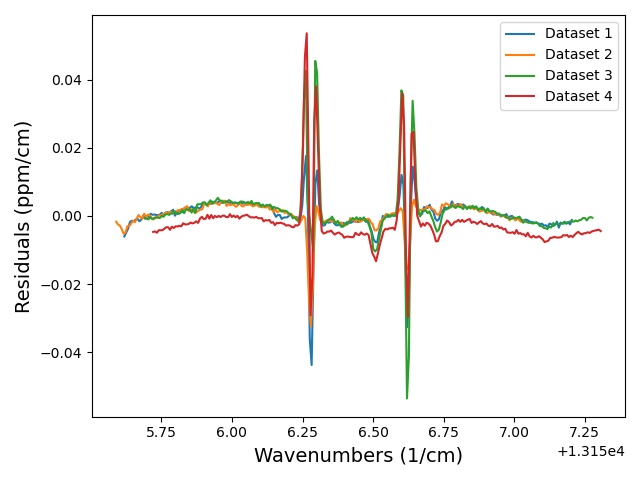

In [34]:
%matplotlib notebook

#Plot residuals
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red']

fig, ax = plt.subplots()

for i in range(len(x)):
    mean, var = gpr.predict_f(x[i])
    mean = noise_scale * mean[:, 0].numpy()
    var = (noise_scale**2) * var[:, 0].numpy()
    #ax.errorbar(x[i][:, 0], mean - y[i], yerr=np.sqrt(var), color=colors[i], alpha=0.5)
    ax.plot(x[i][:, 0], mean - y[i], color=colors[i], label='Dataset %i'%(i+1))

ax.set_ylabel('Residuals (ppm/cm)', fontsize=14)
ax.set_xlabel('Wavenumbers (1/cm)', fontsize=14)
ax.legend()

fig.tight_layout()
plt.show()

<IPython.core.display.Javascript object>


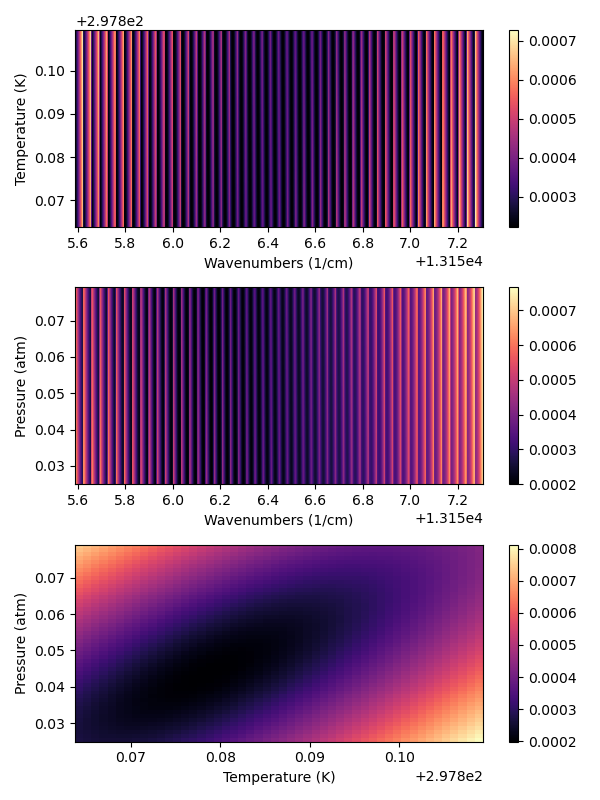

In [35]:
#Look at uncertainty as a function of wavenumber, temperature, pressure
x_vals = np.linspace(np.min(test_x[:, 0]), np.max(test_x[:, 0]), 500)
t_vals = np.linspace(np.min(test_x[:, 1]), np.max(test_x[:, 1]), 50)
p_vals = np.linspace(np.min(test_x[:, 2]), np.max(test_x[:, 2]), 50)

xt_grid = np.vstack([a.flatten() for a in np.meshgrid(x_vals, t_vals)]).T
xt_grid = np.hstack([xt_grid, np.average(p_vals)*np.ones((xt_grid.shape[0], 1))])
xp_grid = np.vstack([a.flatten() for a in np.meshgrid(x_vals, p_vals)]).T
xp_grid = np.vstack([xp_grid[:, 0], np.average(t_vals)*np.ones(xp_grid.shape[0]), xp_grid[:, 1]]).T
tp_grid = np.vstack([a.flatten() for a in np.meshgrid(t_vals, p_vals)]).T
tp_grid = np.hstack([np.average(x_vals)*np.ones((tp_grid.shape[0], 1)), tp_grid])

#Use likelihood for first dataset
xt_grid = np.hstack([xt_grid, np.zeros((xt_grid.shape[0], 1))])
xp_grid = np.hstack([xp_grid, np.zeros((xp_grid.shape[0], 1))])
tp_grid = np.hstack([tp_grid, np.zeros((tp_grid.shape[0], 1))])

fig, ax = plt.subplots(3, figsize=(6, 8))

ax_labels = [('Wavenumbers (1/cm)', 'Temperature (K)'),
             ('Wavenumbers (1/cm)', 'Pressure (atm)'),
             ('Temperature (K)', 'Pressure (atm)')]

shapes = [(500, 50), (500, 50), (50, 50)]

extents = [(xt_grid[0, 0], xt_grid[-1, 0], xt_grid[0, 1], xt_grid[-1, 1]),
           (xp_grid[0, 0], xp_grid[-1, 0], xp_grid[0, 2], xp_grid[-1, 2]),
           (tp_grid[0, 1], tp_grid[-1, 1], tp_grid[0, 2], tp_grid[-1, 2])]

for i, grid in enumerate([xt_grid, xp_grid, tp_grid]):
    mean, var = gpr.predict_f(grid)
    std = noise_scale * np.sqrt(var[:, 0])
    std = np.reshape(std, shapes[i])
    im = ax[i].imshow(std.T, cmap='magma', aspect='auto', origin='lower', extent=extents[i])
    plt.colorbar(im, ax=ax[i])
    ax[i].set_xlabel(ax_labels[i][0])
    ax[i].set_ylabel(ax_labels[i][1])
    
fig.tight_layout()
plt.show()